# JWST Fetch Crowded Field Spectral Products

## Introduction

This tutorial will demonstrate how to use [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) to retrieve JWST data products. Our goal is to retrieve the set of spectral data products needed to run the JWST processing pipeline to perform our own extractions within crowded fields, e.g., within a stellar cluster or the Galactic center.  This notebook walks through the process as follows:

* First we will demonstrate how to use astroquery.mast to perform the three basics of data search and retrieval. We will use images from the Early Relase Observation (ERO) of NGC 3132 (the Southern Ring Nebula) for just this first part.  The basic steps to download data from MAST are:
    1. Conduct a search for observations.
    2. Retrieve the set of products for those observations.
    3. Download the products you want.
* Next we will walk through these steps for a wide-field slitless spectroscopy program, and explain some of the challenges of the steps above when there can be thousands of products associated with the observations.
* Often you will want to perform your own spectral extraction, which you can do by running the JWST processing pipeline, to apply special treatment needed in these crowded fields.  We will show how you can download only the data products needed to perform your own spectral extractions, instead of downloading everything available for your observations.

## Table of Contents
- [Imports](#Imports)<br>
- [The Basics Of Searching and Downloading Data Through astroquery.mast](#The-Basics-Of-Searching-and-Downloading-Data-Through-astroquery.mast)<br>
    - [Step 1: Searching For Observations](#Step-1:-Searching-For-Observations)<br>
        - [Search By Object Coordinates](#Search-By-Object-Coordinates)<br>
        - [Search By Resolvable Object Name](#Search-By-Resolvable-Object-Name)<br>
        - [Search By Observational Metadata](#Search-By-Observational-Metadata)<br>
    - [Step 2: Retrieving Data Products](#Step-2:-Retrieving-Data-Products)
    - [Step 3: Downloading Data Products](#Step-3:-Downloading-Data-Products)

## Imports
* The `Observations` class from the `astroquery.mast` module allows you to query by coordinates, resolvable target names, or observational metadata like program IDs, filters, or exposure times.
* We use the `SkyCoord` class from the `astropy.coordinates` module to define coordinates.
* We use the astropy `Units` module to define physical units.
* We use `fits` module from astropy.io to read data contained in FITS files.
* We import a couple options from `astropy.visualization` for applying scaling and stretches.
* We use `matplotlib.pyplot` for plotting and image display.

In [61]:
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.visualization import ZScaleInterval, SquaredStretch, ImageNormalize
import matplotlib.pyplot as plt

## The Basics Of Searching and Downloading Data Through astroquery.mast

We'll use the ERO observations of the Southern Ring Nebula to show you how to search for observations.  You can use the `Observations` module of `astroquery.mast` in a variety of ways, including [by position](https://astroquery.readthedocs.io/en/latest/mast/mast.html#positional-queries) or by [observational metadata](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries).

### Step 1: Searching For Observations

The first step in downloading JWST data products through `astroquery.mast` is to search for observations of interest.  There are several ways to find observations of interest, in this section, we will demonstrate how to do a cone search by providing coordinates, a cone search by providing a resolvable target namw, and a search based on observational metadata.

#### Search By Object Coordinates.

First, let's search for observations by coordinates of the object directly.

In [2]:
# Define the coordinates of the object.
obj_coords = SkyCoord("10:07:01", "-40:26:14", unit=(u.hourangle, u.deg))

# Conduct a cone search centered on these coordinates.  The default search radius is 0.2 degrees.  Let's use a much
# smaller search radius of one arcminute.
obs_table = Observations.query_region(obj_coords, radius="1.0 arcmin")

We get back an Astropy table containing observations whose footprints fall within our search radius.  But notice that this includes data from lots of missions, e.g., TESS, WUPPE, etc.  This is because the simple cone search operates across all the missions in our cross-mission database.  We'll show later how to do a search and only get back JWST mission data. A description of the columns returned from an observation search are [documented here](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html).

In [23]:
# The show_in_notebook() function allows us to explore an Astropy table with pagination and search capability.
# Try searching for the JWST entries.

# One of the return columns is called the 's_region', which contains the polygonal representation of the footprint
# on the sky.  This is a very long string, and makes viewing the rest of the table difficult in a notebook. So
# we will get a list of all the coumns except this one for display purposes.
display_columns = [x for x in obs_table.columns if x != "s_region"]

# Show the contents of the table.
obs_table[display_columns].show_in_notebook(display_length=5)

idx,intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
0,science,WUPPE,--,ASTRO-2 WUPPE,--,--,UV,NGC3132,--,ngc3132_410911_2,151.7577852819,-40.43465143,spectrum,--,1,49791.03055556,49791.0512963,1792.0,170400000000.0,277400000000.00006,--,nan,--,--,--,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/ngc3132_410911_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/ngc3132_410911_2_hw_vo.fits,PUBLIC,--,5885.0,389320,8.362941846686795
1,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0009-2-2,157.48628713094715,-43.22571855614874,image,"Ricker, George",3,58542.73242914352,58567.9618940162,1425.599414,600.0,1000.0,--,58609.3333334,N/A,--,9,--,--,PUBLIC,False,nan,62894034,0.0
2,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0036-2-1,149.12522577936127,-39.2835424391434,image,"Ricker, George",3,59280.406030439815,59305.4891190625,475.199787,600.0,1000.0,--,59327.0,N/A,--,36,--,--,PUBLIC,False,nan,60827609,0.0
3,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC3,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,5020.0,6410.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch3/pbcd/SPITZER_I3_4416768_0000_7_E8349184_maic.fits,PUBLIC,False,nan,1748827,0.0
4,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC4,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,6430.0,9280.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch4/pbcd/SPITZER_I4_4416768_0000_7_E8348786_maic.fits,PUBLIC,False,nan,1748827,0.0
5,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC1,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,3170.0,3950.0000000000005,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch1/pbcd/SPITZER_I1_4416768_0000_7_A42446629_maics.fits,PUBLIC,False,nan,1748827,0.0
6,science,SPITZER_SHA,SSC Pipeline,IRAC,--,IRAC2,Infrared,NGC 3132,--,000000436500,151.755292,-40.436056,image,"Fazio, Giovanni",3,52993.89252381,52993.89882872,26.8,3990.0,5010.0,Studying Stellar Ejecta on the Large Scale using SIRTF-IRAC,53545.2916667,STELLAREJECTA_68,--,4416768,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRAC003600/r4416768/ch2/pbcd/SPITZER_I2_4416768_0000_7_E8349192_maic.fits,PUBLIC,False,nan,1748827,0.0
7,science,SPITZER_SHA,SSC Pipeline,IRS,--,IRS-LH,Infrared,NGC3132,--,0000010D4700,151.75733300000002,-40.436417,image,"Houck, James R.",3,53914.94061384,53914.94115995,47.183904075063765,18700.0,37200.0,Revealing the nature of Bulge Planetary Nebulae,54308.84664344,JBS2.BULGE_30550,--,17647360,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRSX006800/r17647360/ch3/pbcd/SPITZER_S3_17647360_0006_7_E7480772_coa2d.fits,PUBLIC,False,nan,1697393,0.0
8,science,SPITZER_SHA,SSC Pipeline,IRS,--,IRS-SL,Infrared,NGC 3132 center,--,000001A17900,151.75741700000003,-40.436083,image,"Sellgren, Kris",3,54846.13118598,54846.13189142,60.95001641660929,5200.0,14500.0,Planetary Nebulae As A Laboratory For Molecular Hydrogen in the Early Universe,54894.83368052,PNH2_50179,--,27359488,--,https://irsa.ipac.caltech.edu/data/SPITZER/SHA/archive/proc/IRSX011800/r27359488/ch0/pbcd/SPITZER_S0_27359488_0023_3_E7859719_coa2d.fits,PU

#### Search By Resolvable Object Name.

Instead of specifying the coordinates, you can provide the name of an object as long as it is resolvable by Simbad, NED, or a KIC, EPIC, or TIC catalog name.  This still does a cone search on the sky, by using the resolver service to translate your provided string into a coordinate on the sky.  It does NOT do a string match for the object name in the MAST database!

In [24]:
# Conduct a cone search by passing a resolvable target name.
obs_table = Observations.query_region("NGC 3132", radius="1.0 arcmin")

In [28]:
# Show the contents of the table.
display_columns = [x for x in obs_table.columns if x != "s_region"]
obs_table[display_columns].show_in_notebook(display_length=5)

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
0,image,3,JWST,jw02733-o002_t001_miri_f1130w,NGC 3132,151.7551341666667,-40.43742777777777,59742.52554607129,59742.65142148148,2708.432,Infrared,F1130W,10950.0,11650.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,PUBLIC,False,nan,science,87602450,165448265
1,image,3,JWST,jw02733-o001_t001_nircam_clear-f187n,NGC 3132,151.7551341666667,-40.43742777777777,59733.70454250509,59733.73834347222,9276.576,Infrared,F187N,1863.0,1884.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f187n_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f187n_i2d.fits,PUBLIC,False,nan,science,87602522,165448266
2,image,3,JWST,jw02733-o002_t001_miri_f770w,NGC 3132,151.7551341666667,-40.43742777777777,59742.50030178889,59742.62614372685,2708.432,Infrared,F770W,6600.0,8800.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.fits,PUBLIC,False,nan,science,87602452,165448269
3,image,3,JWST,jw02733-o001_t001_nircam_clear-f090w,NGC 3132,151.7551341666667,-40.43742777777777,59733.74120144838,59733.76518565972,5840.8,Infrared,F090W,795.0,1004.9999999999999,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f090w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f090w_i2d.fits,PUBLIC,False,nan,science,87602454,165448272
4,image,3,JWST,jw02733-o002_t001_miri_f1800w,NGC 3132,151.7551341666667,-40.43742777777777,59742.57449639537,59742.70066068287,2708.432,Infrared,F1800W,16500.0,19500.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.fits,PUBLIC,False,nan,science,87602456,165448274
5,image,3,JWST,jw02733-o001_t001_nircam_clear-f356w,NGC 3132,151.7551341666667,-40.43742777777777,59733.74120218912,59733.76518640047,1460.2,Infrared,F356W,3140.0,3980.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f356w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f356w_i2d.fits,PUBLIC,False,nan,science,87602457,165448276
6,image,3,JWST,jw02733-o001_t001_nircam_clear-f212n,NGC 3132,151.7551341666667,-40.43742777777777,59733.66775883611,59733.70168424769,9276.576,Infrared,F212N,2109.0,2134.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f212n_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f212n_i2d.fits,PUBLIC,False,nan,science,87602523,165448278
7,image,3,JWST,jw02733-o001_t001_nircam_f405n-f444w,NGC 3132,151.7551341666667,-40.43742777777777,59733.66775883611,59733.70168424769,2319.144,Infrared,F444W,3880.0,4986.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_f405n-f444w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_f405n-f444w_i2d.fits,PUBLIC,False,nan,science,87602459,165448282
8,image,3,JWST,jw02733-o002_t001_miri_f1280w,NGC 3132,151.7551341666667,-40.43742777777777,59742.54989271481,59742.67596070602,2708.432,Infrared,F1

#### Search By Observational Metadata.

You can also perform a search by observational metadata like program ID or instruments and filters.  We used the `query_region` function above to do cone searches.  For metadata queries, we'll use the `query_criteria` function.

In [26]:
# Search for all observations for a given JWST proposal ID.  In this case, Program ID 2733, the ERO program.
# Make sure to specify the obs_collection (mission) = JWST to avoid any other data sets that might have a proposal
# ID of 2733, e.g. HST.
obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2733])

In [29]:
# Show the contents of the table.
display_columns = [x for x in obs_table.columns if x != "s_region"]
obs_table[display_columns].show_in_notebook(display_length=5)

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
0,image,3,JWST,jw02733-o002_t001_miri_f1130w,NGC 3132,151.7551341666667,-40.43742777777777,59742.52554607129,59742.65142148148,2708.432,Infrared,F1130W,10950.0,11650.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,PUBLIC,False,nan,science,87602450,165448265
1,image,3,JWST,jw02733-o001_t001_nircam_clear-f187n,NGC 3132,151.7551341666667,-40.43742777777777,59733.70454250509,59733.73834347222,9276.576,Infrared,F187N,1863.0,1884.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f187n_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f187n_i2d.fits,PUBLIC,False,nan,science,87602522,165448266
2,image,3,JWST,jw02733-o002_t001_miri_f770w,NGC 3132,151.7551341666667,-40.43742777777777,59742.50030178889,59742.62614372685,2708.432,Infrared,F770W,6600.0,8800.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.fits,PUBLIC,False,nan,science,87602452,165448269
3,image,3,JWST,jw02733-o001_t001_nircam_clear-f090w,NGC 3132,151.7551341666667,-40.43742777777777,59733.74120144838,59733.76518565972,5840.8,Infrared,F090W,795.0,1004.9999999999999,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f090w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f090w_i2d.fits,PUBLIC,False,nan,science,87602454,165448272
4,image,3,JWST,jw02733-o002_t001_miri_f1800w,NGC 3132,151.7551341666667,-40.43742777777777,59742.57449639537,59742.70066068287,2708.432,Infrared,F1800W,16500.0,19500.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.fits,PUBLIC,False,nan,science,87602456,165448274
5,image,3,JWST,jw02733-o001_t001_nircam_clear-f356w,NGC 3132,151.7551341666667,-40.43742777777777,59733.74120218912,59733.76518640047,1460.2,Infrared,F356W,3140.0,3980.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f356w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f356w_i2d.fits,PUBLIC,False,nan,science,87602457,165448276
6,image,3,JWST,jw02733-o001_t001_nircam_clear-f212n,NGC 3132,151.7551341666667,-40.43742777777777,59733.66775883611,59733.70168424769,9276.576,Infrared,F212N,2109.0,2134.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_clear-f212n_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_clear-f212n_i2d.fits,PUBLIC,False,nan,science,87602523,165448278
7,image,3,JWST,jw02733-o001_t001_nircam_f405n-f444w,NGC 3132,151.7551341666667,-40.43742777777777,59733.66775883611,59733.70168424769,2319.144,Infrared,F444W,3880.0,4986.0,--,JWST Early Release Observation 7,59773.625,NIRCAM,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o001_t001_nircam_f405n-f444w_i2d.jpg,mast:JWST/product/jw02733-o001_t001_nircam_f405n-f444w_i2d.fits,PUBLIC,False,nan,science,87602459,165448282
8,image,3,JWST,jw02733-o002_t001_miri_f1280w,NGC 3132,151.7551341666667,-40.43742777777777,59742.54989271481,59742.67596070602,2708.432,Infrared,F1

In [3]:
# For our final example, let's only search for the MIRI images from this program ID.  You can combine a metadata
# query WITH a cone search on the sky by including a `coordinates` and optional `radius` argument.  Let's do that
# now just for demonstration purposes.

# A metadata search that does not include any cone search component.
obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2733], instrument_name=["MIRI"])

In [2]:
# A metadata search that includes a cone search component.
obj_coords = SkyCoord("10:07:01", "-40:26:14", unit=(u.hourangle, u.deg))

obs_table = Observations.query_criteria(obs_collection=["JWST"], proposal_id=[2733], instrument_name=["MIRI"],
                                        coordinates=obj_coords, radius="1 arcmin")

In [3]:
# Show the contents of the table.
display_columns = [x for x in obs_table.columns if x != "s_region"]
obs_table[display_columns].show_in_notebook(display_length=5)

idx,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
0,image,3,JWST,jw02733-o002_t001_miri_f1130w,NGC 3132,151.7551341666667,-40.43742777777777,59742.52554607129,59742.65142148148,2708.432,Infrared,F1130W,10950.0,11650.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,PUBLIC,False,nan,science,87602450,165448265,165448265,0.0
1,image,3,JWST,jw02733-o002_t001_miri_f770w,NGC 3132,151.7551341666667,-40.43742777777777,59742.50030178889,59742.62614372685,2708.432,Infrared,F770W,6600.0,8800.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f770w_i2d.fits,PUBLIC,False,nan,science,87602452,165448269,165448269,0.0
2,image,3,JWST,jw02733-o002_t001_miri_f1800w,NGC 3132,151.7551341666667,-40.43742777777777,59742.57449639537,59742.70066068287,2708.432,Infrared,F1800W,16500.0,19500.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1800w_i2d.fits,PUBLIC,False,nan,science,87602456,165448274,165448274,0.0
3,image,3,JWST,jw02733-o002_t001_miri_f1280w,NGC 3132,151.7551341666667,-40.43742777777777,59742.54989271481,59742.67596070602,2708.432,Infrared,F1280W,11600.0,14000.0,--,JWST Early Release Observation 7,59773.625,MIRI,"Pontoppidan, Klaus M.",2733,JWST,JWST,--,CALJWST,mast:JWST/product/jw02733-o002_t001_miri_f1280w_i2d.jpg,mast:JWST/product/jw02733-o002_t001_miri_f1280w_i2d.fits,PUBLIC,False,nan,science,87602461,165448284,165448284,0.0


### Step 2: Retrieving Data Products

The second step is to retrieve the data products associated with a table of observations.  Sometimes an observation might have a single products.  Others may have thousands.  For the purpose of this demo, let's just get the data products for the first MIRI observation.

In [7]:
data_products = Observations.get_product_list(obs_table[0])

In [8]:
#TODO: Trying to use data_products.show_in_notebook() crashes the Jupyter instance for some reason! Slicing for now.
# Let's just take a peak at the first 10 products in the returned Astropy table.
data_products[0:10]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str4,str5,str34,str64,str1,str66,str9,str28,str9,str1,str7,str5,str4,str48,int64,str8,str6,int64
87602450,JWST,image,jw02733-o002_t001_miri_f1130w,target (L3) : segmentation map,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_segm.fits,AUXILIARY,Minimum Recommended Products,SEGM,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_segm.fits,8112960,87602450,PUBLIC,3
87602450,JWST,image,jw02733-o002_t001_miri_f1130w,source/target (L3) : association generator,D,mast:JWST/product/jw02733-o002_20220712t201523_image3_003_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.5.3,2733,jw02733-o002_20220712t201523_image3_003_asn.json,5925,87602450,PUBLIC,3
87602450,JWST,image,jw02733-o002_t001_miri_f1130w,source/target (L3) : association pool,D,mast:JWST/product/jw02733_20220712t201523_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.5.3,2733,jw02733_20220712t201523_pool.csv,73986,87602450,PUBLIC,3
87602450,JWST,image,jw02733-o002_t001_miri_f1130w,Preview-Full,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.jpg,PREVIEW,--,--,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_i2d.jpg,126906,87602450,PUBLIC,3
87602450,JWST,image,jw02733-o002_t001_miri_f1130w,target (L3) : source catalog,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_cat.ecsv,SCIENCE,Minimum Recommended Products,CAT,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_cat.ecsv,342331,87602450,PUBLIC,3
87602450,JWST,image,jw02733-o002_t001_miri_f1130w,exposure/target (L2b/L3): rectified 2D image,D,mast:JWST/product/jw02733-o002_t001_miri_f1130w_i2d.fits,SCIENCE,Minimum Recommended Products,I2D,--,CALJWST,1.5.3,2733,jw02733-o002_t001_miri_f1130w_i2d.fits,56692800,87602450,PUBLIC,3
87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115638_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115638_stream.fits,406080,87602450,PUBLIC,1
87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115638_uncal.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115638_uncal.fits,420480,87602450,PUBLIC,1
87599771,JWST,image,jw02733002001_02103_00001_mirimage,FGS1 guide star acquisition,S,mast:JWST/product/jw02733002001_gs-acq1_2022163115724_stream.fits,AUXILIARY,--,GS-ACQ1,--,CALJWST,--,2733,jw02733002001_gs-acq1_2022163115724_stream.fits,406080,87602450,PUBLIC,1


### Step 3: Downloading Data Products

The final step is to download the data products. The cross-mission database defines "Minimum Recommended Products" in guidance with the mission (in this case JWST). Setting this argument to True will only download the most commonly useful products, often calibrated ones. By default, `download_products` will have this set to False and you will download all available products.

In [63]:
# Download the Minimum Recommended Products for our MIRI Observations.
manifest = Observations.download_products(data_products, mrp_only=True)

INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_segm.fits with expected size 8112960. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_20220712t201523_image3_003_asn.json with expected size 5925. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733_20220712t201523_pool.csv with expected size 73986. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_cat.ecsv with expected size 342331. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_i2d.fits with expected size 56692800. [astroquery.query]


In [12]:
# The return is an Astropy table that contains status of your download and the local path where it saved the file.
manifest

Local Path,Status,Message,URL
str98,str8,object,object
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_segm.fits,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_20220712t201523_image3_003_asn.json,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733_20220712t201523_pool.csv,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_cat.ecsv,COMPLETE,None,None
./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_i2d.fits,COMPLETE,None,None


In [31]:
# To complete this part of the tutorial, let's show the image!  First, select the row containing the i2d.fits file.
i2d_file_mask = '_i2d.fits' in manifest['Local Path']

# Store the local path as a scalar string.
i2d_file = manifest[i2d_file_mask]['Local Path']
print(i2d_file)

./mastDownload/JWST/jw02733-o002_t001_miri_f1130w/jw02733-o002_t001_miri_f1130w_segm.fits


In [29]:
# Read in the image data.
image_data = fits.getdata(i2d_file, ext=1)

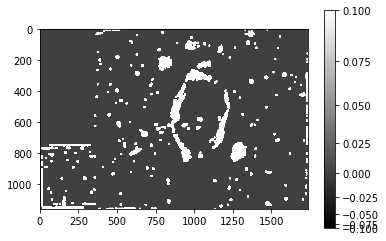

In [62]:
# Show the image.
## TODO: Make this look better, it looks good in ds9 with ZScale + Squared scaling....

norm = ImageNormalize(image_data, interval=ZScaleInterval(),
                      stretch=SquaredStretch())

plt.figure()
plt.imshow(image_data, cmap='gray', norm=norm)
plt.colorbar()

# Short Pause!

Any questions or issues following along as we went through the basic of how to search and download data using the ERO observations of the Southern Ring Nebula?

Next: let's walk through how to download data for observations with LOTS of products and observations.